<a href="https://colab.research.google.com/github/Haripraveen-Chenna/Diabetes_Readmission/blob/main/diabetes_readmission_xgb_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 15.7 MB/s eta 0:00:00
Raw shape: (101766, 50)
Engineered shape: (101766, 55)
Train: (65129, 54) | Val: (16283, 54) | Test: (20354, 54)
Minority: 7269 Majority: 57860
Trained 12 models.
Test ROC-AUC: 0.6876185531596283
Test PR-AUC: 0.23720801445885162
Best threshold: 0.149, F1=0.286

Classification Report:

              precision    recall  f1-score   support

           0      0.920     0.799     0.855     18083
           1      0.217     0.446     0.292      2271

    accuracy                          0.759     20354
   macro avg      0.569     0.622     0.574     20354
weighted avg      0.841     0.759     0.792     20354

Confusion matrix:
 [[14442  3641]
 [ 1259  1012]]


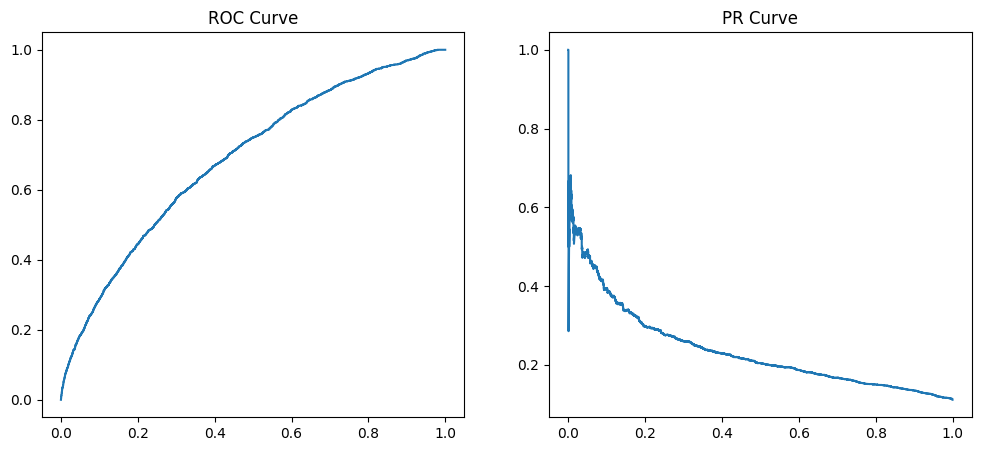

Artifacts saved in /content/ml_artifacts
  adding: content/ml_artifacts/ (stored 0%)
  adding: content/ml_artifacts/feature_columns.json (deflated 62%)
  adding: content/ml_artifacts/ensemble_xgb.pkl (deflated 71%)
  adding: content/ml_artifacts/calibrator.pkl (deflated 38%)
Download ml_artifacts.zip from the left panel.


In [7]:
# ============================
# FULL EASY-ENSEMBLE XGBOOST PIPELINE (ONE CELL)
# ============================

# Install dependencies
!pip install -q xgboost==1.7.6 shap joblib imbalanced-learn==0.11.0

# -------- IMPORTS --------
import os, json, random, warnings
import numpy as np
import pandas as pd
import joblib
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, roc_auc_score, average_precision_score,
    f1_score, confusion_matrix, precision_recall_curve,
    roc_curve, auc
)
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample

import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

warnings.filterwarnings("ignore")
RSEED = 42
np.random.seed(RSEED)
random.seed(RSEED)

SAVE_DIR = "/content/ml_artifacts"
os.makedirs(SAVE_DIR, exist_ok=True)

# ============================
# LOAD DATA
# ============================

DATA_PATH = "/content/diabetic_data.csv"   # <-- upload before running

if not Path(DATA_PATH).exists():
    raise FileNotFoundError("Upload diabetic_data.csv to /content or update DATA_PATH")

df = pd.read_csv(DATA_PATH)
print("Raw shape:", df.shape)

# ============================
# TARGET CLEANING
# ============================
df = df.replace("?", np.nan)
df["readmitted"] = df["readmitted"].replace({">30":0, "<30":1, "NO":0}).astype(int)

# Drop IDs
for c in ["encounter_id", "patient_nbr"]:
    df = df.drop(columns=c, errors="ignore")

# ============================
# FEATURE ENGINEERING
# ============================
def map_icd(code):
    if pd.isna(code): return "unknown"
    c = str(code).split('.')[0]
    try: i = int(c)
    except: return "other"
    if 1<=i<=139: return "infectious"
    if 140<=i<=239: return "neoplasm"
    if 240<=i<=279: return "endocrine"
    if 280<=i<=289: return "blood"
    if 290<=i<=319: return "mental"
    if 320<=i<=389: return "nervous"
    if 390<=i<=459: return "circulatory"
    if 460<=i<=519: return "respiratory"
    if 520<=i<=579: return "digestive"
    if 580<=i<=629: return "genitourinary"
    if 630<=i<=679: return "pregnancy"
    if 680<=i<=709: return "skin"
    if 710<=i<=739: return "musculoskeletal"
    if 740<=i<=759: return "congenital"
    if 760<=i<=779: return "perinatal"
    if 780<=i<=799: return "symptoms"
    if 800<=i<=999: return "injury_poison"
    return "other"

work = df.copy()

# ICD groups
for d in ["diag_1","diag_2","diag_3"]:
    if d in work:
        work[f"{d}_group"] = work[d].astype(str).apply(map_icd)
        work.drop(columns=d, inplace=True, errors="ignore")

# age → numeric
def age_num(x):
    bins = {'[0-10)':5,'[10-20)':15,'[20-30)':25,'[30-40)':35,'[40-50)':45,'[50-60)':55,
            '[60-70)':65,'[70-80)':75,'[80-90)':85,'[90-100)':95}
    return bins.get(str(x), 50)
work['age_num'] = work['age'].apply(age_num)

# numeric fixes
nums = ["number_outpatient","number_emergency","number_inpatient",
        "num_medications","number_diagnoses","time_in_hospital"]
for c in nums:
    if c in work: work[c] = pd.to_numeric(work[c], errors="coerce").fillna(0).astype(int)

if all(c in work for c in ["number_outpatient","number_emergency","number_inpatient"]):
    work["total_visits"] = work["number_outpatient"] + work["number_emergency"] + work["number_inpatient"]

if "insulin" in work: work["insulin_flag"] = (work["insulin"].astype(str).str.lower()!="no").astype(int)
if "diabetesMed" in work: work["diabetes_med_flag"] = (work["diabetesMed"].astype(str)=="Yes").astype(int)
if "change" in work: work["change_flag"] = (work["change"].astype(str)=="Ch").astype(int)

if "time_in_hospital" in work and "number_diagnoses" in work:
    work["severity_index"] = work["time_in_hospital"]*(work["number_diagnoses"]+1)

work["comorbidity_score"] = 0
if "num_medications" in work: work["comorbidity_score"] += (work["num_medications"]>10).astype(int)
if "number_diagnoses" in work: work["comorbidity_score"] += (work["number_diagnoses"]>8).astype(int)
if "time_in_hospital" in work: work["comorbidity_score"] += (work["time_in_hospital"]>6).astype(int)
work["comorbidity_score"] += (work["age_num"]>=75).astype(int)

print("Engineered shape:", work.shape)

# ============================
# FEATURE SELECTION + ENCODING
# ============================

TARGET = "readmitted"
X = work.drop(columns=[TARGET])
y = work[TARGET]

selected = []
for c in X.columns:
    if X[c].dtype.kind in "biufc": selected.append(c)
    else:
        if X[c].nunique() <= 200: selected.append(c)

X = X[selected]

# Label encode categorical
cat_cols = X.select_dtypes(include=["object"]).columns
le_map = {}
for c in cat_cols:
    X[c] = X[c].astype(str).fillna("missing")
    le = LabelEncoder()
    X[c] = le.fit_transform(X[c])
    le_map[c] = le

# Fill numeric missing
for c in X.columns:
    if c not in cat_cols:
        X[c] = pd.to_numeric(X[c], errors="coerce").fillna(X[c].median())

# ============================
# SPLIT DATA
# ============================

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RSEED, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.20, random_state=RSEED, stratify=y_trainval)

print("Train:", X_train.shape, "| Val:", X_val.shape, "| Test:", X_test.shape)

# ============================
# EASY-ENSEMBLE (XGBOOST)
# ============================

N_MODELS = 12
models = []
val_probs_list = []

xgb_params = {
    "n_estimators": 300,
    "max_depth": 5,
    "learning_rate": 0.05,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "use_label_encoder": False,
    "eval_metric": "logloss",
    "random_state": RSEED,
}

train_df = X_train.copy()
train_df["__y"] = y_train

minor = train_df[train_df["__y"]==1]
major = train_df[train_df["__y"]==0]

print("Minority:", len(minor), "Majority:", len(major))

for i in range(N_MODELS):
    maj_sample = resample(major, replace=False, n_samples=len(minor), random_state=RSEED+i)
    batch = pd.concat([minor, maj_sample]).sample(frac=1.0, random_state=RSEED+i)

    y_tr = batch["__y"].values
    X_tr = batch.drop(columns="__y")

    model = xgb.XGBClassifier(**xgb_params)
    model.fit(X_tr, y_tr)
    models.append(model)

    val_probs_list.append(model.predict_proba(X_val)[:,1])

print(f"Trained {len(models)} models.")

# ============================
# CALIBRATION
# ============================

val_avg = np.mean(val_probs_list, axis=0)
calibrator = LogisticRegression()
calibrator.fit(val_avg.reshape(-1,1), y_val)

test_model_probs = np.mean([m.predict_proba(X_test)[:,1] for m in models], axis=0)
test_cal = calibrator.predict_proba(test_model_probs.reshape(-1,1))[:,1]

print("Test ROC-AUC:", roc_auc_score(y_test, test_cal))
print("Test PR-AUC:", average_precision_score(y_test, test_cal))

# ============================
# THRESHOLD TUNING
# ============================

def tune_threshold(probs, y, low=0.01, high=0.8, steps=200):
    best_t, best_f = 0.5, -1
    for t in np.linspace(low, high, steps):
        pred = (probs >= t).astype(int)
        f = f1_score(y, pred)
        if f > best_f:
            best_f = f
            best_t = t
    return best_t, best_f

best_t, best_f = tune_threshold(calibrator.predict_proba(val_avg.reshape(-1,1))[:,1], y_val)
print(f"Best threshold: {best_t:.3f}, F1={best_f:.3f}")

test_pred = (test_cal >= best_t).astype(int)
print("\nClassification Report:\n")
print(classification_report(y_test, test_pred, digits=3))

cm = confusion_matrix(y_test, test_pred)
print("Confusion matrix:\n", cm)

# ============================
# PLOTS
# ============================

fpr, tpr, _ = roc_curve(y_test, test_cal)
prec, rec, _ = precision_recall_curve(y_test, test_cal)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr)
plt.title("ROC Curve")

plt.subplot(1,2,2)
plt.plot(rec, prec)
plt.title("PR Curve")
plt.show()

# ============================
# SAVE ARTIFACTS
# ============================

joblib.dump(models, f"{SAVE_DIR}/ensemble_xgb.pkl")
joblib.dump(calibrator, f"{SAVE_DIR}/calibrator.pkl")
json.dump(list(X.columns), open(f"{SAVE_DIR}/feature_columns.json","w"), indent=2)

print("Artifacts saved in", SAVE_DIR)

# Zip artifacts for download
!zip -r /content/ml_artifacts.zip /content/ml_artifacts
print("Download ml_artifacts.zip from the left panel.")
